# Facial Recog Library Test

Install Guide:
https://github.com/ageitgey/face_recognition

In [1]:
from PIL import Image, ImageDraw
import face_recognition
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp

In [ ]:
image = face_recognition.load_image_file("Facial_Recog_test/testface.jpg")


In [ ]:
# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

print("I found {} face(s) in this photograph.".format(len(face_landmarks_list)))

# Create a PIL imagedraw object so we can draw on the picture
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))
        print("Number of Landmarks: {}".format(len(face_landmarks[facial_feature])))
    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=5) 

# Show the picture
pil_image.show()
pil_image.save('Facial_Recog_test/testface_landmarks.jpg')

### Facial Landmarks Detection


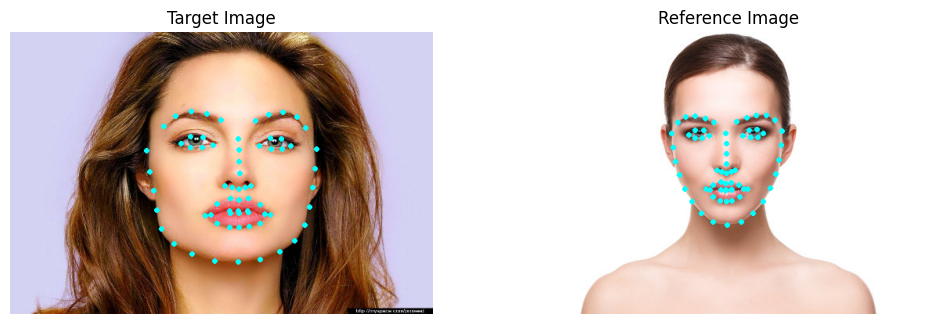

In [2]:
# get the face landmarks of both faces
trgt_img = face_recognition.load_image_file("Facial_Recog_test/face_target.jpg")
ref_img = face_recognition.load_image_file("Facial_Recog_test/face_ref.jpg")

trgt_img = cv2.resize(trgt_img, (ref_img.shape[1], ref_img.shape[0]))

trgt_img_landmarks = face_recognition.face_landmarks(trgt_img)
ref_img_landmarks = face_recognition.face_landmarks(ref_img)

trgt_img_landmarks_np = np.empty((0,2), dtype=int)
ref_img_landmarks_np = np.empty((0,2), dtype=int)

for face_landmarks in trgt_img_landmarks:
    for facial_feature in face_landmarks.keys():
        trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, face_landmarks[facial_feature], axis=0)

for face_landmarks in ref_img_landmarks:
    for facial_feature in face_landmarks.keys():
        ref_img_landmarks_np = np.append(ref_img_landmarks_np, face_landmarks[facial_feature], axis=0)

# draw landmarks over the face

pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(pil_image1)
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(pil_image2)
plt.axis('off')
plt.title('Reference Image')
plt.show()


### Facial Warping

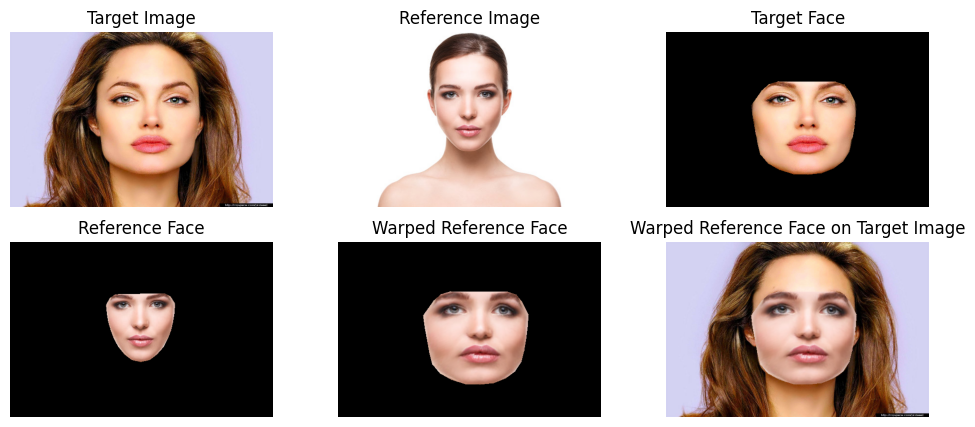

In [3]:
transform = PiecewiseAffineTransform()
transform.estimate(trgt_img_landmarks_np, ref_img_landmarks_np)

ref_face_hull = cv2.convexHull(ref_img_landmarks_np).astype(np.int32)
ref_face_mask = np.zeros(ref_img.shape[:2], dtype=np.float32)
cv2.fillConvexPoly(ref_face_mask, ref_face_hull, 1)
ref_face_mask = ref_face_mask > 0
ref_face = np.zeros_like(ref_img)
ref_face[ref_face_mask] = ref_img[ref_face_mask]

warped_ref_face = (warp(ref_img, transform, output_shape=trgt_img.shape) * 255).astype(np.uint8)

mask = (warped_ref_face != 0).all(axis=2)

warped_ref_face_on_trgt = warped_ref_face * mask[:,:,None] + trgt_img * ~mask[:,:,None]
warped_ref_face_on_trgt = warped_ref_face_on_trgt.astype(np.uint8)

trgt_face = trgt_img * mask[:,:,None]

plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(trgt_img)
plt.axis('off')
plt.title("Target Image")
plt.subplot(232)
plt.imshow(ref_img)
plt.axis('off')
plt.title("Reference Image")
plt.subplot(233)
plt.imshow(trgt_face)
plt.axis('off')
plt.title("Target Face")
plt.subplot(234)
plt.imshow(ref_face)
plt.axis('off')
plt.title("Reference Face")
plt.subplot(235)
plt.imshow(warped_ref_face)
plt.axis('off')
plt.title("Warped Reference Face")
plt.subplot(236)
plt.imshow(warped_ref_face_on_trgt)
plt.axis('off')
plt.title("Warped Reference Face on Target Image")
plt.show()



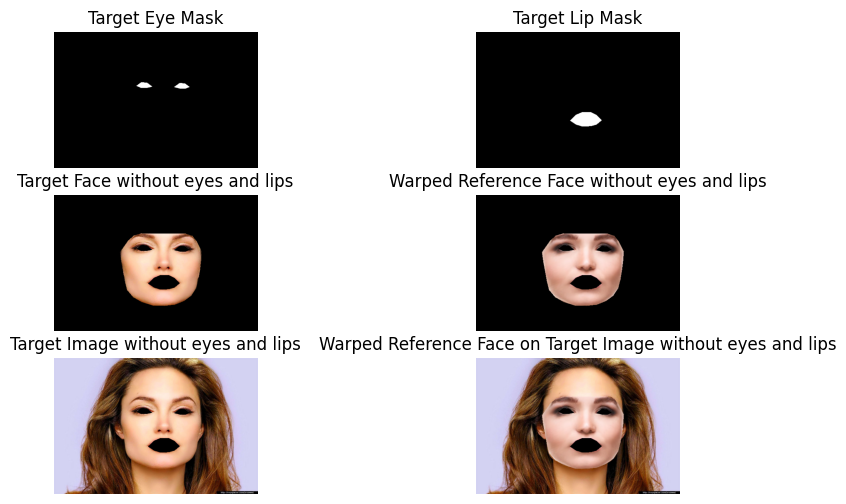

In [4]:
# remove eyes and lips from the target face by creating a mask of the eye region
trgt_left_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['left_eye']))
trgt_right_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['right_eye']))
trgt_top_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['top_lip']))
trgt_bottom_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['bottom_lip']))

trgt_left_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_right_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_top_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_bottom_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)

cv2.fillConvexPoly(trgt_left_eye_mask, trgt_left_eye, 1)
cv2.fillConvexPoly(trgt_right_eye_mask, trgt_right_eye, 1)
cv2.fillConvexPoly(trgt_top_lip_mask, trgt_top_lip, 1)
cv2.fillConvexPoly(trgt_bottom_lip_mask, trgt_bottom_lip, 1)

trgt_eye_mask = trgt_left_eye_mask + trgt_right_eye_mask
trgt_lip_mask = trgt_top_lip_mask + trgt_bottom_lip_mask
trgt_lip_mask[trgt_lip_mask > 1] = 1

# combine the masks
eye_lip_mask = trgt_eye_mask + trgt_lip_mask
eye_lip_mask[eye_lip_mask > 1] = 1

# remove the eyes and lips from the target face and the warped reference face
trgt_face_without_eye_lip = trgt_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_without_eye_lip = warped_ref_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

trgt_img_without_eye_lip = trgt_img * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_on_trgt_without_eye_lip = warped_ref_face_on_trgt * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

plt.figure(figsize=(10,6))
plt.subplot(321)
plt.imshow(trgt_eye_mask, cmap='gray')
plt.axis('off')
plt.title("Target Eye Mask")
plt.subplot(322)
plt.imshow(trgt_lip_mask, cmap='gray')
plt.axis('off')
plt.title("Target Lip Mask")
plt.subplot(323)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Target Face without eyes and lips")
plt.subplot(324)
plt.imshow(warped_ref_face_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(325)
plt.imshow(trgt_img_without_eye_lip)
plt.axis('off')
plt.title("Target Image without eyes and lips")
plt.subplot(326)
plt.imshow(warped_ref_face_on_trgt_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face on Target Image without eyes and lips")
plt.show()


### Linear Color Scaling of Reference Face to Match Target Face

Scaling Factor for channel 0 : 1.0673366834170854
Scaling Factor for channel 1 : 1.0321608040201005
Scaling Factor for channel 2 : 0.9165829145728643


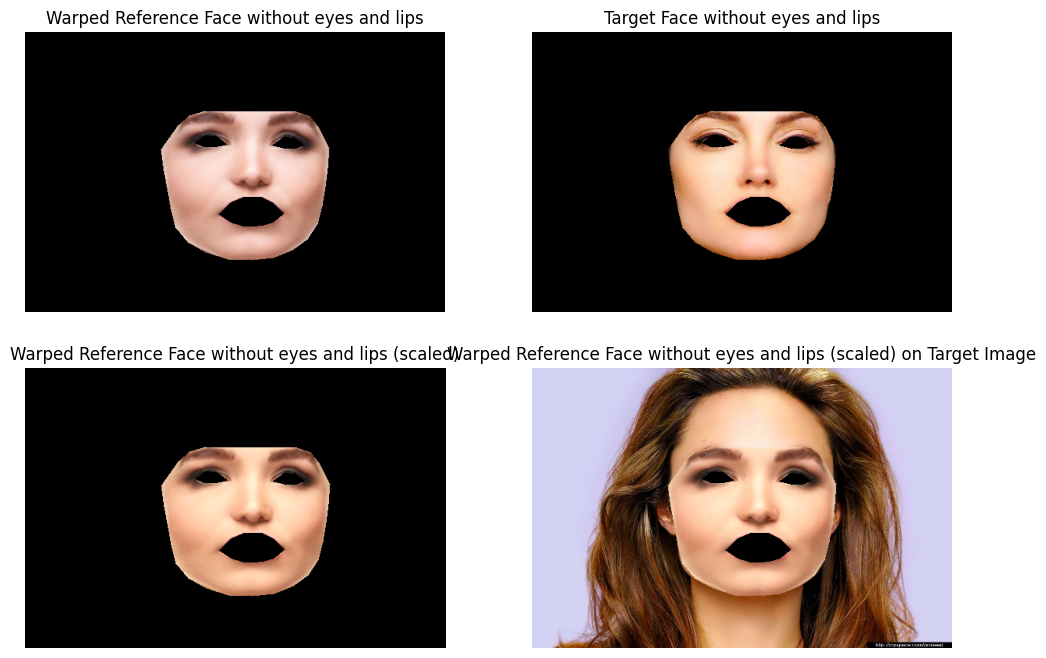

In [92]:
def linearColorScaling(warped_ref_face_without_eye_lip, trgt_face_without_eye_lip, face_mask):

    # scale the warped reference face to match the color of the target face. adjust the scaling factor to get the best result
    warped_ref_face_without_eye_lip_scaled = np.empty_like(warped_ref_face_without_eye_lip, dtype=np.float64)

    scaling_factors = np.linspace(0.6, 1.6, 200)

    for i in range(3):
        min_error = np.inf
        for scaling_factor in scaling_factors:
            a = warped_ref_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            b = trgt_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            a *= scaling_factor
            #a = np.clip(a, 0, 255)
            error = np.sum((a - b) ** 2)
            if error < min_error:
                min_error = error
                best_scaling_factor = scaling_factor
        
        warped_ref_face_without_eye_lip_scaled[:,:,i] = warped_ref_face_without_eye_lip[:,:,i].astype(np.float64) * best_scaling_factor
        warped_ref_face_without_eye_lip_scaled[:,:,i] = np.clip(warped_ref_face_without_eye_lip_scaled[:,:,i], 0, 255)

        #print("Scaling Factor for channel {} : {}".format(i, best_scaling_factor))

    warped_ref_face_without_eye_lip_scaled[~face_mask] = 0
    
    return warped_ref_face_without_eye_lip_scaled.astype(np.uint8)

face_mask = mask - eye_lip_mask
face_mask = face_mask.astype(bool)

warped_ref_face_without_eye_lip_scaled = linearColorScaling(warped_ref_face_without_eye_lip, trgt_face_without_eye_lip, face_mask)

warped_ref_face_without_eye_lip_scaled_on_trgt = warped_ref_face_without_eye_lip_scaled * face_mask[:,:,None] + trgt_img_without_eye_lip * ~face_mask[:,:,None]

# show the original and scaled warped reference face
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(warped_ref_face_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(222)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Target Face without eyes and lips")
plt.subplot(223)
plt.imshow(warped_ref_face_without_eye_lip_scaled)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips (scaled)")
plt.subplot(224)
plt.imshow(warped_ref_face_without_eye_lip_scaled_on_trgt)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips (scaled) on Target Image")
plt.show()


### Otsu's Method

In [ ]:
import numpy as np

def compute_otsu_criteria(im, th):
    """Otsu's method to compute criteria."""
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

im = # load your image as a numpy array.
# For testing purposes, one can use for example im = np.random.randint(0,255, size = (50,50))

# testing all thresholds from 0 to the maximum of the image
threshold_range = range(np.max(im)+1)
criterias = [compute_otsu_criteria(im, th) for th in threshold_range]

# best threshold is the one minimizing the Otsu criteria
best_threshold = threshold_range[np.argmin(criterias)]